In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
from summit.models import GPyModel
from summit.data import solvent_ds,DataSet
from surrogate_model_functions import DirectOpt, plot_3d_model, loo_error, get_cas_number

import GPy
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import urllib3
import pickle

In [3]:
#Import experimental results and replace solvent names with CAS numbers
experimental_datafile = 'yehia_thesis_solvent_selection_results.csv'
results = DataSet.read_csv(experimental_datafile)
http = urllib3.PoolManager()
try:
    with open('cas_numbers.pickle', 'rb') as f:
        cas_numbers = pickle.load(f)
except FileNotFoundError:
    cas_numbers = [get_cas_number(http, name.values[0]) 
                   for _, name in results['solvent'].iterrows()]
    with open('cas_numbers.pickle', 'wb') as f:
        pickle.dump(cas_numbers,f)
results['cas_number'] = cas_numbers
results = results.set_index('cas_number')
results = results.drop(columns='solvent')

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning:dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [4]:
#Get descriptors for the solvents used in experiments
experimental_descriptors = solvent_ds.merge(results, left_index=True, right_index=True)
outputs = experimental_descriptors[['conversion', 'diasteromeric_excess']]
experimental_descriptors = experimental_descriptors.drop(columns=['conversion', 'diasteromeric_excess'])

In [68]:
#Transform to principal componets
num_components = 6
pca = PCA(n_components=num_components)
pca.fit(solvent_ds.standardize())
pcs = pca.fit_transform(experimental_descriptors.standardize())
explained_var = round(pca.explained_variance_ratio_.sum()*100)
expl = f"{explained_var}% of variance is explained by {num_components} principal components."
print(expl)

93.0% of variance is explained by 6 principal components.


In [69]:
kernels = [0, 0]
kernels[0] = GPy.kern.Matern52(input_dim = num_components, ARD=True)
# kern1 = GPy.kern.PeriodicMatern52(input_dim = num_components, ARD=True, active_dims=[1, 0]) *  \
kernels[1] = GPy.kern.Matern52(input_dim = num_components, ARD=True, [])
optimizer = DirectOpt()
models = [GPyModel(kernel=kernels[i]) for i in range(2)]
outputs_arr = outputs.standardize()
for i, model in enumerate(models):
    Y = outputs_arr[:, i]
    Y = np.atleast_2d(Y).T
    model.fit(pcs, Y,num_restarts=100)

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:in

In [77]:
errors = [loo_error(pcs, np.atleast_2d(outputs_arr[:, i]).T, num_restarts=20)
          for i in range(2)]
errors = [round(error*100, 1) for error in errors]
print(f"Conversion model leave-one-out cross-validation error: {errors[0]}%")
print(f"Enantiomeric Excess model leave-one-out cross-validation error: {errors[1]}%")

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Conversion model leave-one-out cross-validation error: 14.3%
Enantiomeric Excess model leave-one-out cross-validation error: 29.4%


In [75]:
likelihood_1 = models[0]._model.log_likelihood()
print(f"Conversion model likelihood: {likelihood_1}")
models[0]._model.kern.lengthscale

Conversion model likelihood: -16.04584147743622


index,GP_regression.Mat52.lengthscale,constraints,priors
[0],5.79964567,+ve,
[1],15.90848224,+ve,
[2],13.29832492,+ve,
[3],22.98590152,+ve,
[4],64586.05165033,+ve,
[5],63168.33760899,+ve,


In [86]:
likelihood_2 = models[1]._model.log_likelihood()
noise_2 = models[1]._model.Gaussian_noise.variance.values[0]
print(f"DE model likelihood: {likelihood_2}")
print(f"DE model noise: {noise_2}")
models[1]._model.kern.lengthscale

DE model likelihood: -22.80643877842521
DE model noise: 5.562684646268137e-309


index,GP_regression.Mat52.lengthscale,constraints,priors
[0],4.81595969,+ve,
[1],259867.94499419,+ve,
[2],0.85577656,+ve,
[3],162358.05642637,+ve,
[4],5.97920616,+ve,
[5],26973.29357788,+ve,


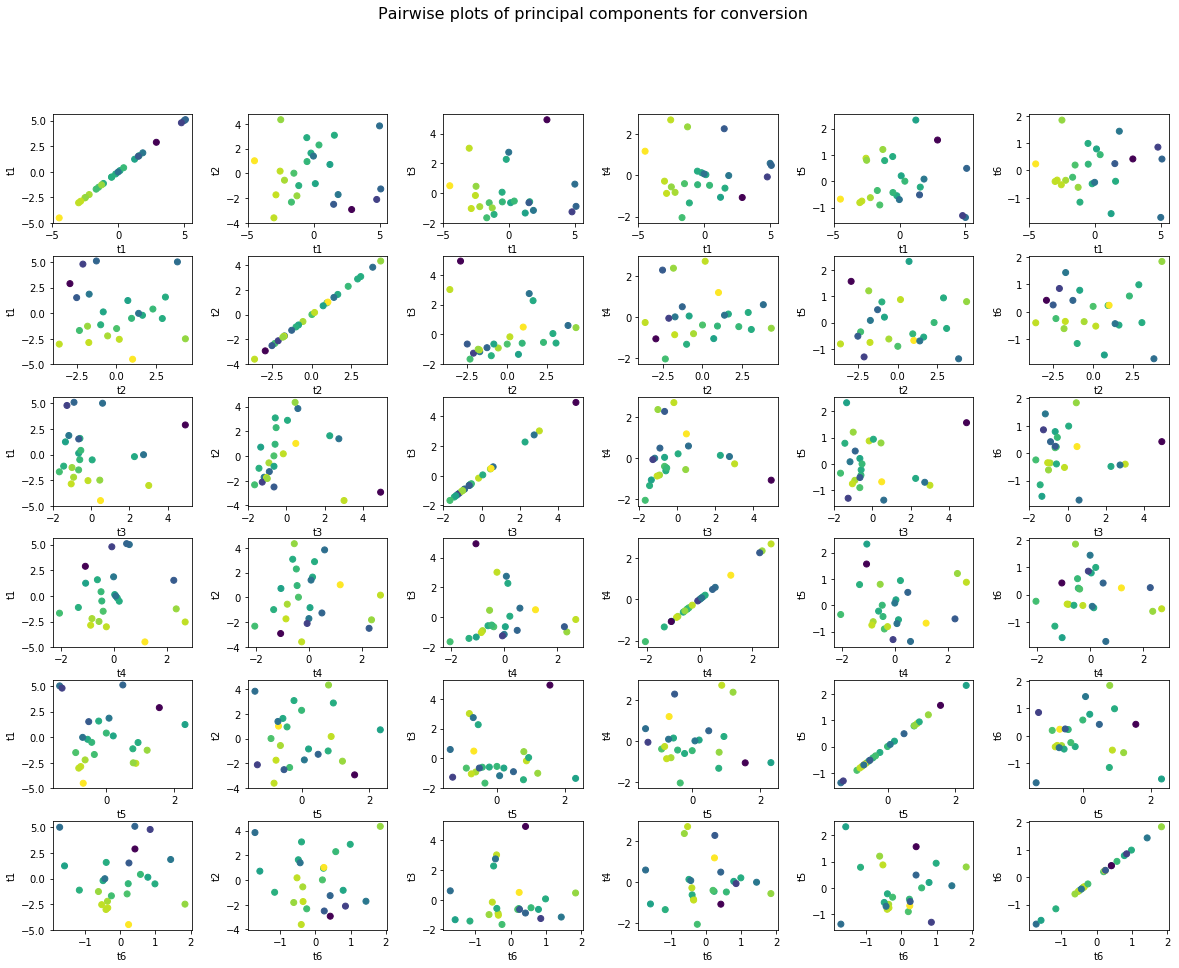

In [151]:
fig, axes = plt.subplots(6, 6, figsize=(20, 15))
fig.suptitle('Pairwise plots of principal components for conversion', fontsize=16)
fig.subplots_adjust(hspace=0.3, wspace=0.4)
row=0; column=0
for i in range(6):
    for j in range(6):
        axes[row, column].scatter(pcs[:, i], pcs[:, j], c=outputs_arr[:, 0])
        axes[row, column].set_xlabel(f't{i+1}'); axes[row, column].set_ylabel(f't{j+1}')
        if column==5:
            row+=1
            column=0
        else:
            column+=1

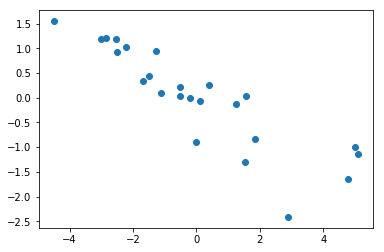

In [164]:
plt.figure()
_  = plt.scatter(pcs[:, 0], outputs_arr[:, 0])

In [166]:
pcs_full = pca.transform(solvent_ds.standardize())
ix = np.argmin(pcs_full[:, 0])
good_solvent = solvent_ds.iloc[ix, :]['cosmo_name'].values[0]
print(f"Likely a good solvent for conversion: {good_solvent}")

Likely a good solvent for conversion: n-hexadecane


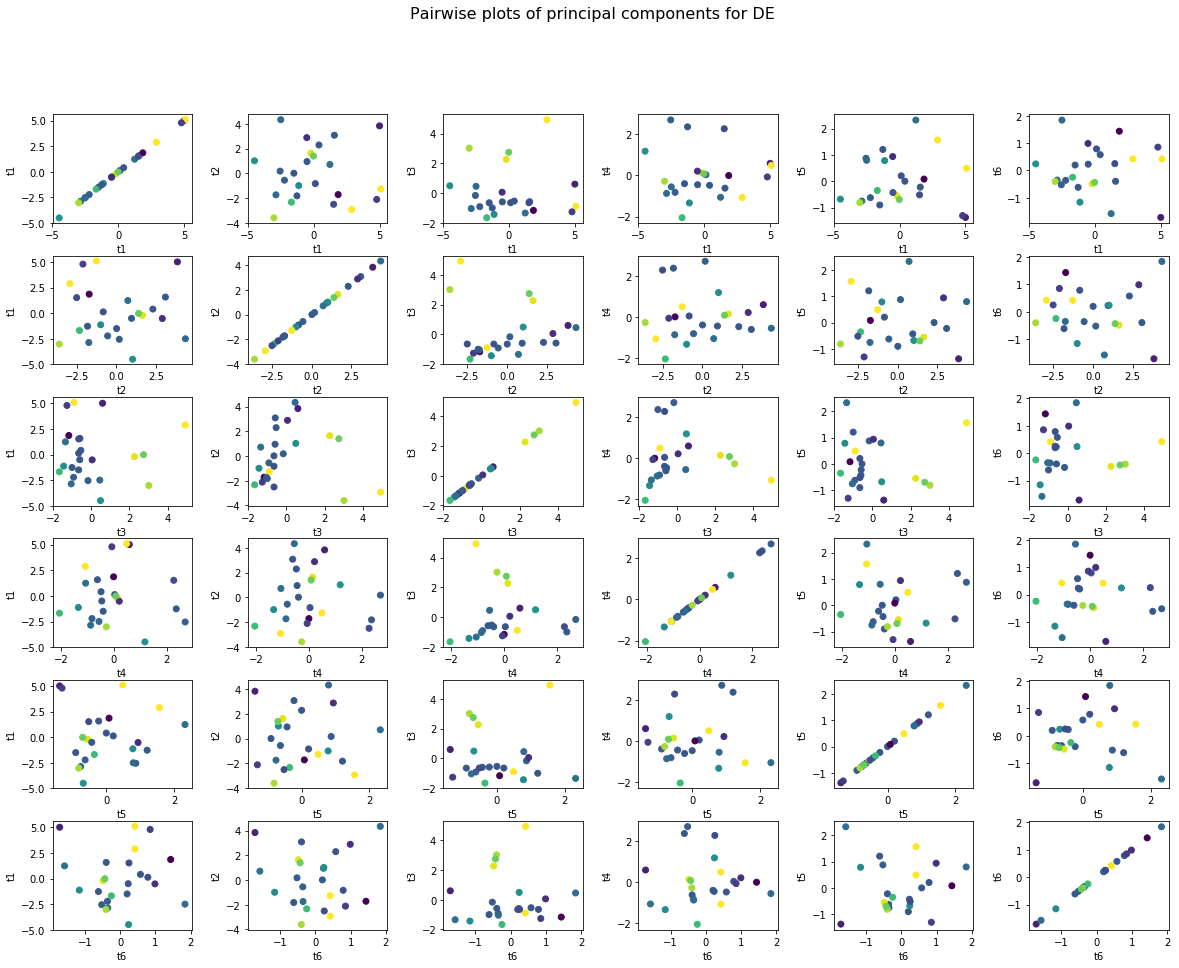

In [149]:
fig, axes = plt.subplots(6, 6, figsize=(20, 15))
fig.suptitle('Pairwise plots of principal components for DE', fontsize=16)
fig.subplots_adjust(hspace=0.3, wspace=0.4)
row=0; column=0
for i in range(6):
    for j in range(6):
        axes[row, column].scatter(pcs[:, i], pcs[:, j], c=outputs_arr[:, 1])
        axes[row, column].set_xlabel(f't{i+1}'); axes[row, column].set_ylabel(f't{j+1}')
        if column==5:
            row+=1
            column=0
        else:
            column+=1

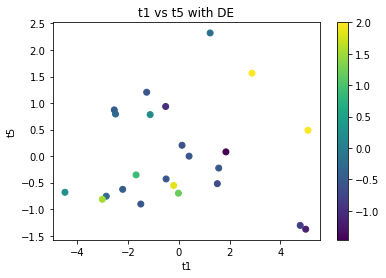

In [165]:
plt.figure()
plt.scatter(pcs[:, 0], pcs[:, 4], c=outputs_arr[:,1])
plt.xlabel('t1'); plt.ylabel('t5')
plt.title('t1 vs t5 with DE')
_ = plt.colorbar()

In [137]:
kernel_de = GPy.kern.Matern52(input_dim = 2, ARD=True)
kernel_de.lengthscale = (1000, 100)
model_de = GPyModel(kernel=kernel_de)
Y = outputs_arr[:, 1]
Y = np.atleast_2d(Y).T
model_de.fit(pcs[:, [0, 4]], Y, max_iters=2000, num_restarts=20)

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [138]:
likelihood_3 = model_de._model.log_likelihood()
noise_3 = model_de._model.Gaussian_noise.variance.values[0]
print(f"DE model likelihood: {likelihood_3}")
print(f"DE model noise: {noise_3}")
model_de._model.kern.lengthscale

DE model likelihood: -32.5370105117116
DE model noise: 1.067446385810473e-08


index,GP_regression.Mat52.lengthscale,constraints,priors
[0],0.15765788,+ve,
[1],0.68885588,+ve,


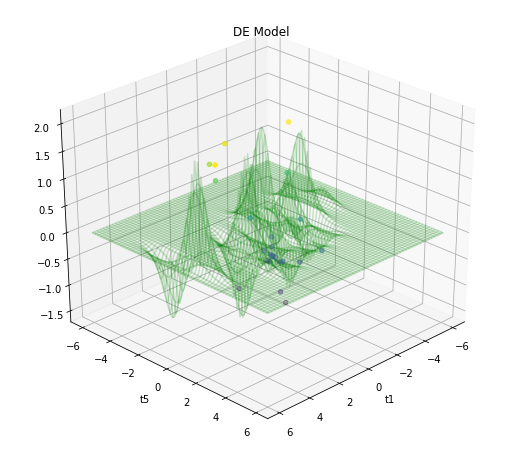

In [139]:
#Plot models
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(pcs[:, 2], pcs[:, 4], outputs_arr[:, 1], c=outputs_arr[:, 1])
ax.set_xlabel('t1'); ax.set_ylabel('t5')
plot_3d_model(ax, model_de._model)
ax.set_title('DE Model')
ax.view_init(30,45)